# Use Case 2: Semantic Search with Text Embeddings

### imports

In [3]:
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.metrics import DistanceMetric

import matplotlib.pyplot as plt
import matplotlib as mpl

c:\Users\PREM RAJ NAGARWAL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


### load data

In [4]:
df_resume = pd.read_csv('resumes_train.csv')
df_resume['role'][df_resume['role'].iloc[-1] == df_resume['role']] = "Other" # relabel random role as "other"
print(len(df_resume))
df_resume.head()

100


,resume,role
0,### John Doe\n\n---\n\n#### Summary\nDetail-or...,Data Scientist
1,Creating a resume for a Data Scientist based o...,Data Scientist
2,Creating a resume for a Data Scientist...\n\n-...,Data Scientist
3,Creating a resume for a Data Scientist based o...,Data Scientist
4,## John Doe\n\n---\n\n### Summary:\nData Scien...,Data Scientist


### generate embeddings

In [5]:
# import pre-trained model (full list: https://www.sbert.net/docs/pretrained_models.html)
model = SentenceTransformer("all-MiniLM-L6-v2")

# embed vectors
embedding_arr = model.encode(df_resume['resume'])
embedding_arr.shape

(100, 384)

### Visualize Embeddings

#### PCA

In [6]:
# apply PCA to embeddings
pca = PCA(n_components=2).fit(embedding_arr)
print(pca.explained_variance_ratio_)

[0.20212616 0.12736866]


In [7]:
np.where(df_resume['role']== 'Data Scientist')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39], dtype=int64),)

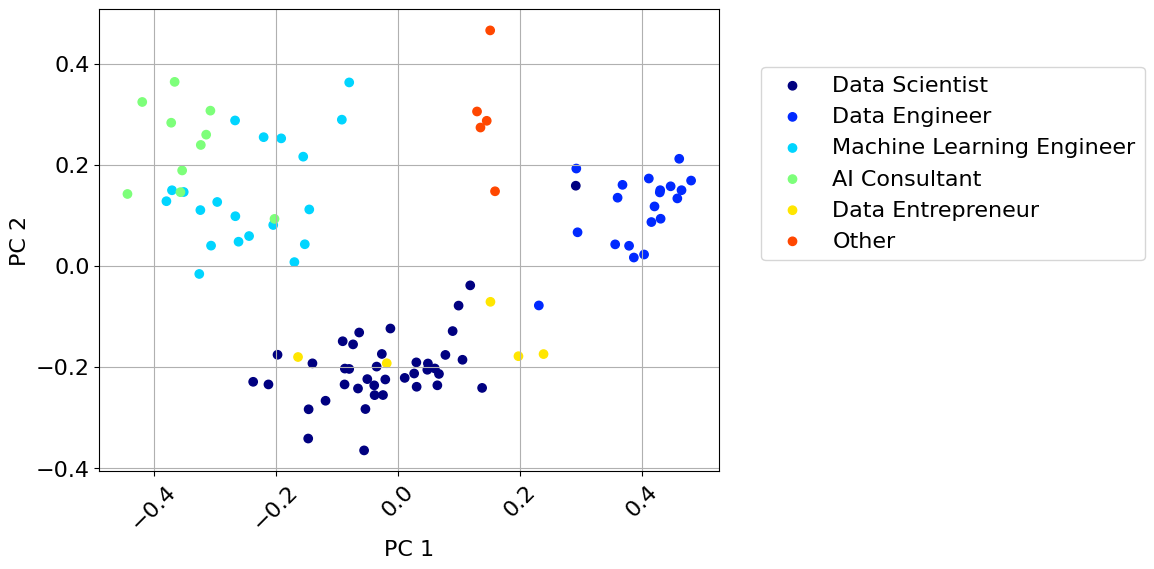

In [8]:
# plot data along PCA components
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.grid()

c=0
cmap = mpl.colormaps['jet']
for role in df_resume['role'].unique():
    idx = np.where(df_resume['role']==role)
    plt.scatter(pca.transform(embedding_arr)[idx,0], pca.transform(embedding_arr)[idx,1], c=[cmap(c)]*len(idx[0]), label=role)
    c = c + 1/len(df_resume['role'].unique())
    
plt.legend(bbox_to_anchor=(1.05, 0.9))
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

### Semantic Search

In [37]:
# query = "I need someone to build out my data infrastructure"   # Good result with semantic search
# query = "Co-founder for marketing analytics consultancy"
# query = "Project manager for AI feature development"

query = "Data Engineer with Apache Airflow experience"           #Bad result with semantic search

In [38]:
# embed query
query_embedding = model.encode(query)
len(query_embedding)

384

In [39]:
# define distance metric
dist = DistanceMetric.get_metric('euclidean') # other distances: manhattan, chebyshev

# compute pair wise distances between query embedding and all resume embeddings
dist_arr = dist.pairwise(embedding_arr, query_embedding.reshape(1,-1)).flatten()  #.reshape(1,-1) convert query_embedding into a row array
# sort results
idist_arr_sorted = np.argsort(dist_arr)

In [40]:
# print roles of top 10 closest resumes to query in embedding space
print(df_resume['role'].iloc[idist_arr_sorted[:10]])

48    Data Engineer
51    Data Engineer
47    Data Engineer
46    Data Engineer
41    Data Engineer
55    Data Engineer
53    Data Engineer
40    Data Engineer
57    Data Engineer
50    Data Engineer
Name: role, dtype: object


In [45]:
# print resume closest to query in embedding space
print(df_resume['resume'].iloc[idist_arr_sorted[2]])

**Name:** John Smith

---

**Summary:**
Experienced and detail-oriented Data Engineer with a passion for transforming raw data into valuable insights. Proficient in designing and implementing data pipelines, data modeling, and data warehousing. Strong background in programming languages such as Python and SQL.

---

**Professional Experience:**

**Data Engineer**
ABC Tech Solutions, Anytown
March 2018 - Present

- Developed and maintained scalable data pipelines using Apache Spark and Airflow.
- Collaborated with cross-functional teams to design and implement data models for business intelligence reporting.
- Optimized database performance by tuning SQL queries and indexing strategies.
- Automated data processing tasks, reducing manual efforts by 30%.

**Junior Data Engineer**
XYZ Analytics, Sometown
June 2016 - February 2018

- Assisted in building ETL processes for extracting, transforming, and loading data into the data warehouse.
- Conducted data quality checks and implemented data

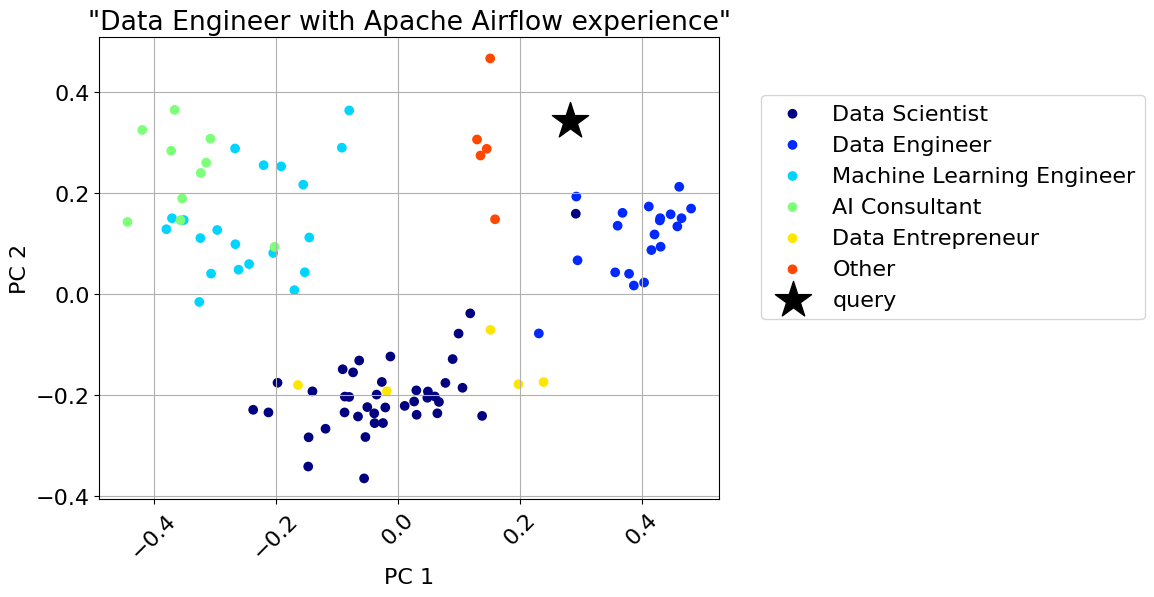

In [36]:
# plot query along with resumes using PCA components
query_pca = pca.transform(query_embedding.reshape(1, -1))[0]

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.grid()

c=0
cmap = mpl.colormaps['jet']
for role in df_resume['role'].unique():
    idx = np.where(df_resume['role']==role)
    plt.scatter(pca.transform(embedding_arr)[idx,0], pca.transform(embedding_arr)[idx,1], c=[cmap(c)]*len(idx[0]), label=role)
    c = c + 1/len(df_resume['role'].unique())

plt.scatter(query_pca[0], query_pca[1], c='k', marker='*', s=750, label='query')
    
plt.legend(bbox_to_anchor=(1.05, 0.9))
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title('"' + query + '"')
plt.show()